In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding Shapely

import matplotlib.pyplot as plt
import contextily
import pandas as pd
import geopandas as gpd
import pymssql
from shapely import wkb
from tobler.area_weighted import area_interpolate
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file and set the environment variable 'PROJ_LIB' to use the right file path
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

In [2]:
database = 'Pushing-P-DB'
table1 = 'dbo.NJ_Cities'
table2 = 'dbo.NJ_Census_Tracts'
user = 'pushing_p'
password  = 't3stP@ssword'
server = 'gen10-data-fundamentals-22-02-sql-server.database.windows.net'


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)

# Query select all rows from SQL tables to insert into their respective DataFrames
query1 = f'SELECT * FROM {table1}'
query2 = f'SELECT * FROM {table2}'
df = pd.read_sql(query1, conn)
tract_info = pd.read_sql(query2, conn)

# Use a function to convert wkb_hex string in SQL database to polygonal geometries (WKB stands for Well-Known Binary, which is commonly used for encoding geographic polygons)
# WKT, well-known text, markup can also be used

def convert_to_polygon(line):
    return wkb.loads(line, hex=True)
df['geometry'] = df['geometry'].apply(convert_to_polygon)
tract_info['geometry'] = tract_info['geometry'].apply(convert_to_polygon)

# Convert from pandas to geopandas dataframes
df = gpd.GeoDataFrame(df, geometry=df['geometry'], crs = 'epsg:4269')
tract_info = gpd.GeoDataFrame(tract_info, geometry=tract_info['geometry'], crs = 'epsg:4269')

# Add % Uninsured Column
df['% Uninsured'] = df['Uninsured Population']/df['City Population']*100
tract_info['% Uninsured'] = tract_info['Uninsured Population']/tract_info['City Population']*100


In [3]:
df.head()

,State,City,County,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",geometry,% Uninsured
0,New Jersey,Union Township,Hunterdon County,4.1,109577,4726,53,0,7,0,...,19,34,37,0,0,0,0,16,"POLYGON ((-75.04588 40.63111, -74.97916 40.657...",1.121456
1,New Jersey,South Bound Brook Borough,Somerset County,8.4,86667,4541,432,23,26,28,...,231,201,159,0,17,62,0,112,"POLYGON ((-74.54279 40.55520, -74.53715 40.558...",9.513323
2,New Jersey,Chesilhurst Borough,Camden County,6.3,71875,1435,124,0,0,0,...,105,19,96,16,0,0,0,0,"POLYGON ((-74.89497 39.72492, -74.89114 39.734...",8.641115
3,New Jersey,Millstone Township,Monmouth County,3.8,177500,10418,144,0,6,0,...,86,58,123,1,0,19,0,1,"POLYGON ((-74.54327 40.21669, -74.48148 40.242...",1.382223
4,New Jersey,Branchville Borough,Sussex County,6.6,96563,1054,40,0,0,7,...,40,0,40,0,0,0,0,0,"POLYGON ((-74.76022 41.14773, -74.75836 41.150...",3.795066


In [4]:
df.shape

(559, 25)

In [5]:
tract_info.head()

,State,County,Census Tract,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders",geometry,"NUI, American Indian & Alaska Native Population",% Uninsured
0,New Jersey,Bergen County,Census Tract 120.02,6.3,85602.0,3728.0,246.0,5.0,0.0,35.0,...,113.0,133.0,144.0,0.0,54,38.0,0.0,"POLYGON ((-74.11939 40.85102, -74.11934 40.853...",54.0,6.598712
1,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,NaN,"POLYGON ((-74.06749 40.71857, -74.06673 40.720...",NaN,NaN
2,New Jersey,Mercer County,Census Tract 30.09,11.5,69052.0,5990.0,444.0,0.0,12.0,45.0,...,398.0,46.0,403.0,18.0,0,23.0,0.0,"POLYGON ((-74.69241 40.21257, -74.68845 40.218...",0.0,7.412354
3,New Jersey,Bergen County,Census Tract 393,4.3,128239.0,2675.0,106.0,0.0,6.0,6.0,...,55.0,51.0,72.0,0.0,0,0.0,0.0,"POLYGON ((-74.26398 41.01427, -74.25753 41.016...",0.0,3.962617
4,New Jersey,Passaic County,Census Tract 1754.01,8.7,42454.0,5336.0,1521.0,78.0,164.0,259.0,...,872.0,649.0,1067.0,13.0,0,0.0,0.0,"POLYGON ((-74.13534 40.87082, -74.12966 40.872...",0.0,28.504498


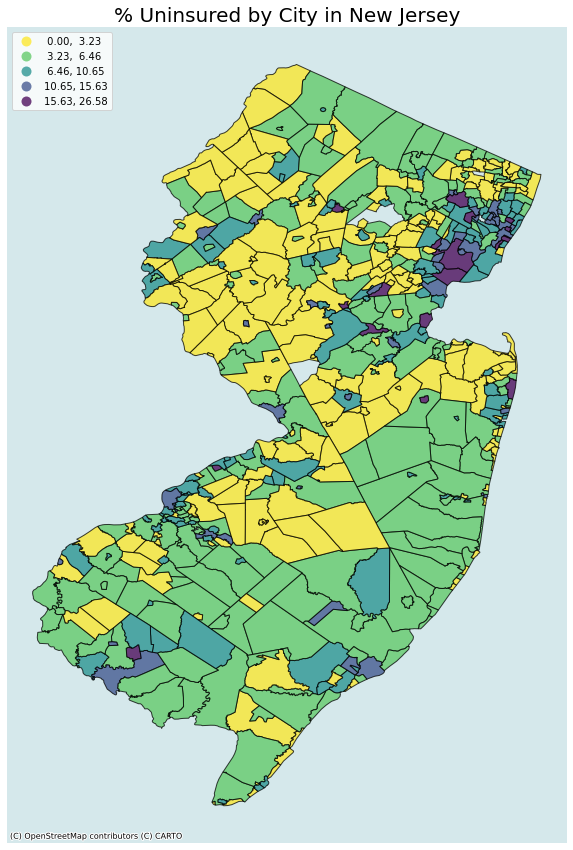

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
df.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Voyager,
)

plt.title('% Uninsured by City in New Jersey', fontsize=20)
ax.set_axis_off();

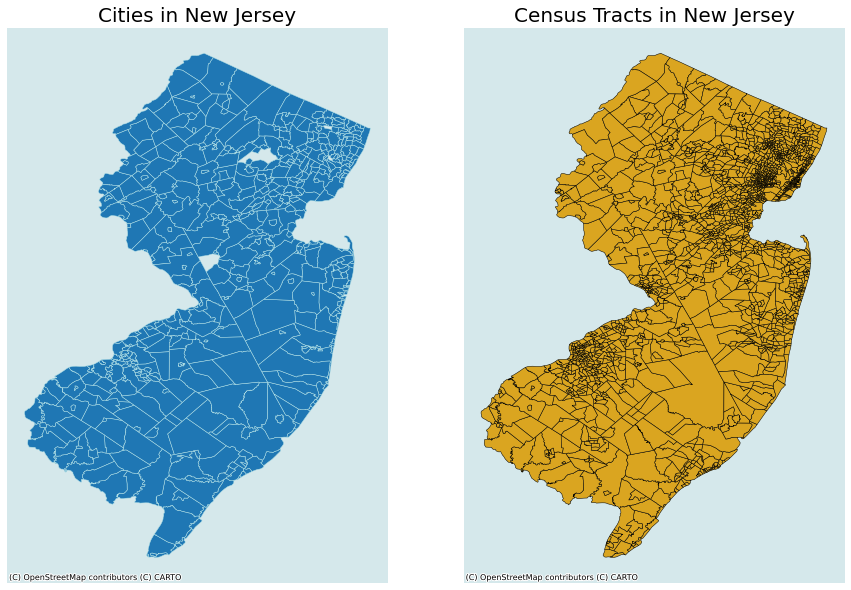

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,20))

df.plot(ax=ax[0], edgecolor = 'powderblue', linewidth = 0.5)
tract_info.plot(ax=ax[1], color = 'goldenrod',edgecolor = 'black', linewidth = 0.5)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)
ax[0].set_title('Cities in New Jersey', fontsize=20)
ax[1].set_title('Census Tracts in New Jersey', fontsize=20)
ax[0].axis('off')
ax[1].axis('off');


#### Areal Interpolation:
- Areal interpolation is the process making estimates from a source set of polygons to an overlapping but incongruent set of target polygons. 

- The simplest technique available in `tobler` is **simple areal interpolation** in which variables from the source data are weighted according to the overlap between source and target polygons, then reaggregated to fit the target polygon geometries

In [8]:
# Drop rows with null values (about 175 counties are missing healthcare information so we drop those from our analysis)
tract_info.dropna(inplace=True)
tract_info.shape

(1809, 25)

In [9]:
extensive_variables = list(df.drop(['State','County','City','geometry','Unemployment Rate (16 & Over)', '% Uninsured'], axis=1).columns)
results = area_interpolate(source_df=df, target_df=tract_info, intensive_variables = ['Unemployment Rate (16 & Over)'], extensive_variables=extensive_variables)

In [10]:
results.head()

,Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years","NUI, 55 to 64 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Natives","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders","NUI, Other Races",Unemployment Rate (16 & Over),geometry
0,7188.236452,907.224966,59.451791,3.089621,5.991992,3.276870,10.954109,16.665226,14.792729,4.681243,...,32.394204,27.057587,40.258693,0.000000,5.055743,13.201106,0.000000,0.936249,3.8,"POLYGON ((-74.11939 40.85102, -74.11934 40.853..."
1,3689.872859,3930.433919,231.399421,1.723477,15.057744,31.975028,71.932474,54.561643,34.650952,20.182819,...,128.353658,103.045763,142.277535,51.795010,0.000000,8.617383,0.453546,20.500302,5.6,"POLYGON ((-74.69241 40.21257, -74.68845 40.218..."
2,36269.790472,3300.360876,185.913942,0.000000,31.330901,4.401862,17.866382,50.750881,57.483141,12.946653,...,78.456719,107.457223,143.448919,17.607449,0.000000,3.107197,0.000000,21.750378,3.4,"POLYGON ((-74.26398 41.01427, -74.25753 41.016..."
3,3706.263297,5761.638282,1387.024282,20.443669,90.134231,196.656504,333.885664,377.256038,258.401349,103.377093,...,801.358700,585.665582,803.593433,93.527714,10.842593,13.491166,0.000000,226.204640,10.1,"POLYGON ((-74.13534 40.87082, -74.12966 40.872..."
4,73203.000000,2267.000000,81.000000,0.000000,0.000000,12.000000,37.000000,0.000000,12.000000,20.000000,...,47.000000,34.000000,53.000000,15.000000,0.000000,0.000000,0.000000,13.000000,11.2,"POLYGON ((-75.03537 39.22675, -75.03467 39.229..."


In [11]:
# Create Uninsurance rate columns

results['% Uninsured'] = results['Uninsured Population']/results['City Population']*100
results['% African'] = results['NUI, African American']/results['Uninsured Population']*100
tract_info['% African'] = tract_info['NUI, African American']/tract_info['Uninsured Population']*100
results['% White'] = results['NUI, White']/results['Uninsured Population']*100
tract_info['% White'] = tract_info['NUI, White']/tract_info['Uninsured Population']*100

results.shape

(1809, 24)

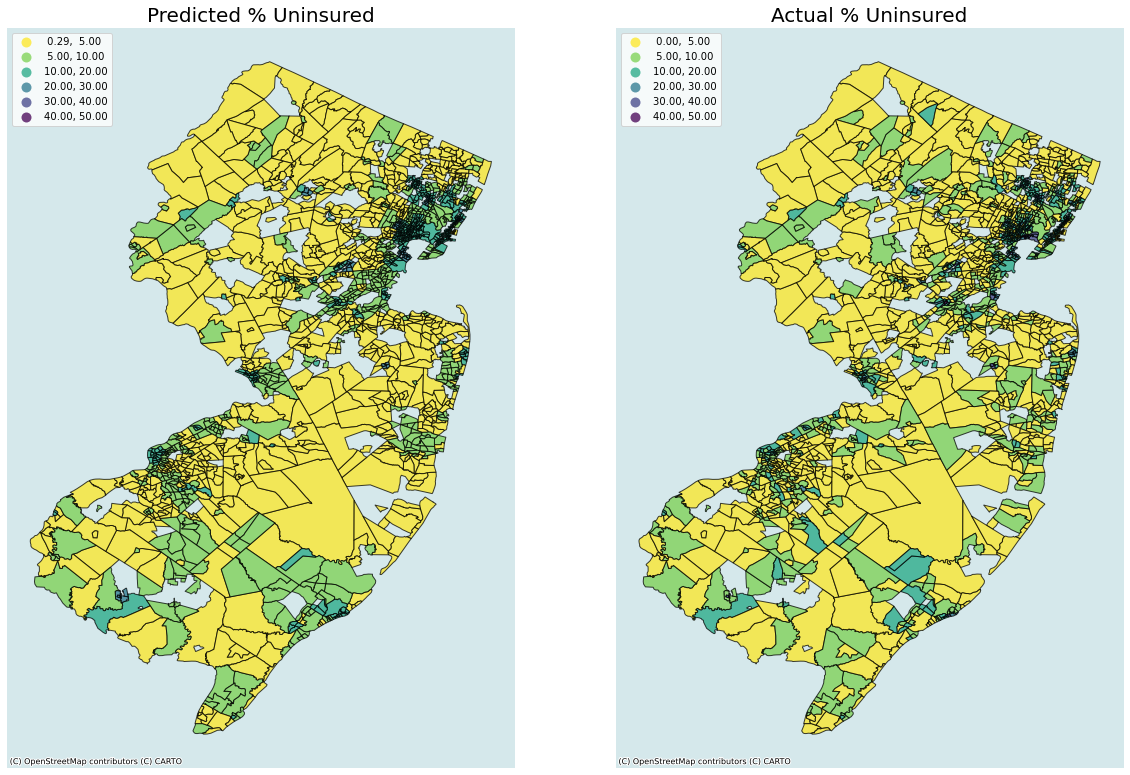

In [12]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% Uninsured', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured',fontsize=20)
ax[1].set_title('Actual % Uninsured',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

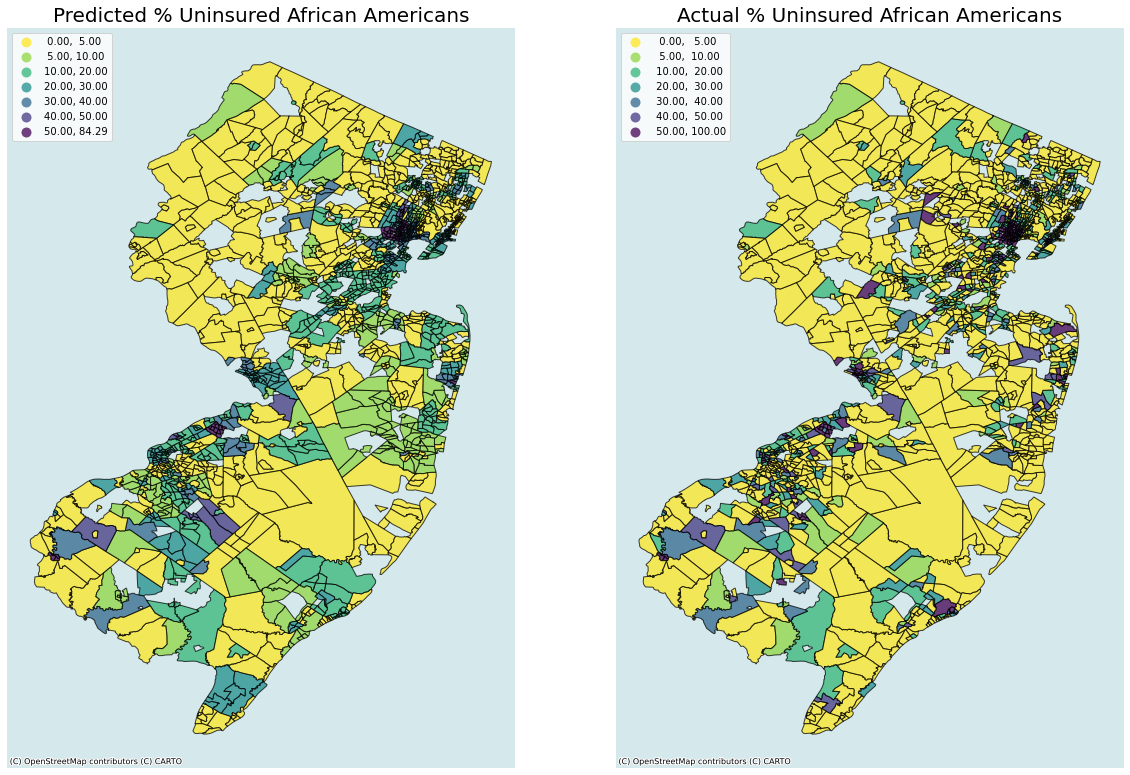

In [13]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% African', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[5,10,20,30,40,50]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured African Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured African Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

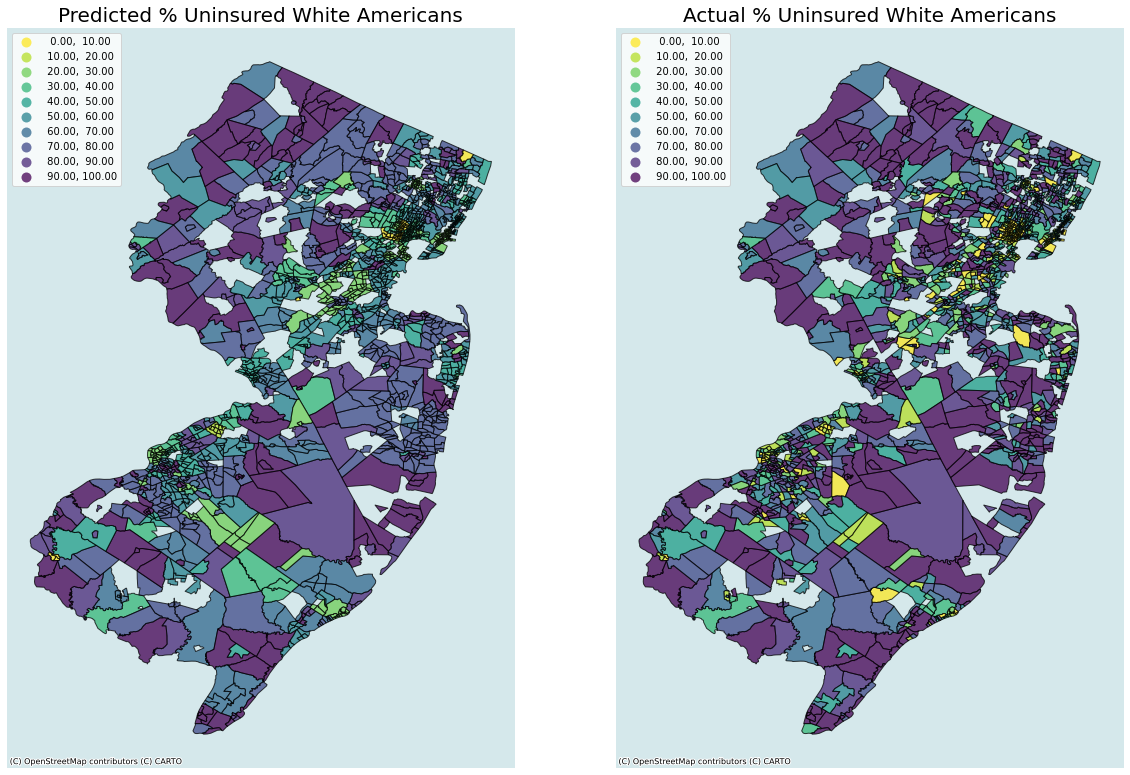

In [14]:
# Set up figure and a single axis
f, ax = plt.subplots(1,2, figsize=(20, 20))

# Build Predicted choropleth
results.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[0]
)

# Build choropleth
tract_info.plot(
    column='% White', 
    cmap='viridis_r', 
    scheme="User_Defined",
    classification_kwds=dict(bins=[10,20,30,40,50,60,70,80,90,100]),
    edgecolor='black', 
    linewidth=1, 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax[1]
)


# Add basemap
contextily.add_basemap(
    ax[0], 
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    ax[1], 
    source=contextily.providers.CartoDB.Voyager
)

ax[0].set_title('Predicted % Uninsured White Americans',fontsize=20)
ax[1].set_title('Actual % Uninsured White Americans',fontsize=20)
ax[0].axis('off')
ax[1].axis('off');

In [15]:
# Export Model using joblib

from joblib import dump
dump(results, 'areal interpolation joblib.model')

['areal interpolation joblib.model']